### Imports and loads

In [22]:
import sys, yaml
from copy import deepcopy
sys.path.append('../lib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit
from prettytable import PrettyTable
from stat_utils import correlation_from_covariance

In [2]:
from spdc_model_utils import countProbaIdler, countProbaSignal
from spdc_model_utils import countProbaS1S2, countProbaiS, countProbai12
from spdc_model_utils import g2_0

In [3]:
lambda_s0 = pd.read_csv('../data/schmidt_eigenvalues.csv', index_col=0)
df = pd.read_csv('../data/measured_rates_etaAndMu.csv')
with open('../data/efficiencies_estimation.yml', 'r') as fileIn:
    eta0 = yaml.load(fileIn, Loader=yaml.Loader)
for k in eta0.keys():
    eta0[k[-1]] = eta0.pop(k)

### Definitions

In [4]:
class FitResults:
    def __init__(self, mu=df['mu0'], mu_err=df['mu0_err'], eta=eta0, 
                 rate=1e6, rate_err=1.3,
                 k=2.71, k_err=0.2, 
                 modLambda=0, modLambda_err=0):
        self.mu = mu
        self.mu_err = mu_err
        self.rate = rate
        self.rate_err = rate_err
        self.eta = eta
        self.k = k
        self.k_err = k_err
        self.modLambda = modLambda
        self.modLambda_err = modLambda_err

In [5]:
def getLambda(modLambda):
    varName = 'sigma_xy_Up' if modLambda >= 0 else 'sigma_xy_Dw'
    return lambda_s0['central'] + np.abs(modLambda)*(lambda_s0[varName] - lambda_s0['central'])

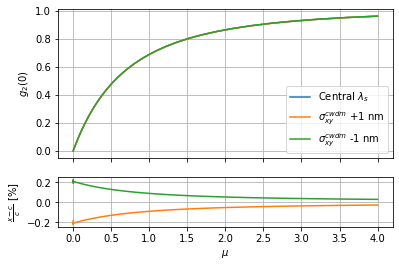

In [6]:
test_mu = np.logspace(-4, np.log10(4), 100)
fig1, (axu, axd) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

yc = g2_0(test_mu, 0.3, 0.4, 0.35, 3., getLambda(0))
axu.plot(test_mu, yc, label='Central $\lambda_s$')
yu = g2_0(test_mu, 0.3, 0.4, 0.35, 3., getLambda(1))
axu.plot(test_mu, yu, label='$\sigma_{xy}^{cwdm}$ +1 nm')
yd = g2_0(test_mu, 0.3, 0.4, 0.35, 3., getLambda(-1))
axu.plot(test_mu, yd, label='$\sigma_{xy}^{cwdm}$ -1 nm')
axu.legend(loc='best')
axd.plot(test_mu, 100*(yu - yc)/yc, color='C1')
axd.plot(test_mu, 100*(yd - yc)/yc, color='C2')
axd.set_xlabel(r'$\mu$')
axu.set_ylabel(r'$g_2(0)$')
axd.set_ylabel(r'$\frac{x - c}{c}$ [%]')
axd.grid()
axu.grid()

In [7]:
def plotSingleDetectors(data=df, fr=None, saveas=None):
    lambdas = getLambda(fr.modLambda)
    plt.rcParams.update({'font.size': 16})
    fig1, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    axs[0,0].set_title('Idler detector')
    axu = axs[0,0]
    axd = axs[1,0]
    
    detectors = {'Ci_tot': 'Threshold', 'Ci_single': 'PNR'}
    kappa = {'Ci_tot': 0, 'Ci_single': fr.k}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        yModel = countProbaIdler(fr.mu, fr.eta['i'][0], kappa[n], lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaIdler(fr.mu+dx, fr.eta['i'][0], kappa[n], lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    axs[0,1].set_title('Signal detectors')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['C1_tot', 'Signal 1'], ['C2_tot', 'Signal 2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaSignal(fr.mu, fr.eta[str(i+1)][0], lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaSignal(fr.mu+dx, fr.eta[str(i+1)][0], lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()
    if saveas is not None:
        fig1.saveas(saveas, bbox_inches='tight')

In [8]:
def plotTwofold(data=df, fr=None, saveas=None):
    lambdas = getLambda(fr.modLambda)
    plt.rcParams.update({'font.size': 16})
    fig1, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    axs[0,0].set_title('Threshold detectors')
    axu = axs[0,0]
    axd = axs[1,0]
    
    detectors = {'Ci1_thr': 'Idler & S1', 'Ci2_thr': 'Idler & S2', 'C12': 'S1 & S2'}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        
        def model(x):
            if n.startswith('Ci1'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['1'][0], k=0, lambdas=lambdas)
            elif n.startswith('Ci2'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['2'][0], k=0, lambdas=lambdas)
            elif n.startswith('C12'):
                return countProbaS1S2(x, fr.eta['1'][0], fr.eta['2'][0], lambdas=lambdas)
                    
        yModel = model(fr.mu)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - model(fr.mu+dx)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    
    
    axs[0,1].set_title('PNR detector')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['Ci1_pnr', 'Idler & S1'], ['Ci2_pnr', 'Idler & S2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()
    if saveas is not None:
        fig1.saveas(saveas, bbox_inches='tight')

In [9]:
def plot_g2_0(data=df, fr=None, figsize=(8,6), drawIdealModels=False, saveas=None, showLegend=True):
    lambdas = getLambda(fr.modLambda)
    plt.rcParams.update({'font.size': 18})
    fig1, (axu, axd) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    detectors = [['g2_pnr', 'PNR'], ['g2_thr', 'Threshold']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]
        yerr = data[n+'_err']
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        
        K = fr.k if i == 0 else 0
        yModel = g2_0(fr.mu, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - g2_0(fr.mu+dx, fr.eta['i'][0], fr.eta['1'][0], fr.eta['2'][0], K, lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    
    if drawIdealModels:
        test_mu = np.logspace(-4, max(np.log10(0.015), np.log10(np.max(fr.mu))), 100)
        y = g2_0(test_mu, 0.87, 0.87, 0.87, fr.k, lambdas)
        axu.plot(test_mu, y, color='C2', ls='-', label=r'PNR: $\eta=0.87$, k={:.2f}'.format(fr.k))
        y = g2_0(test_mu, 0.87, 0.87, 0.87, 10, lambdas)
        axu.plot(test_mu, y, color='C3', ls='-', label=r'PNR: $\eta=0.87$, k=10')
        
    axu.grid()
    axd.grid()
    axu.set_ylabel(r'$g_2(0)$')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    if showLegend:
        axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()
    if saveas is not None:
        fig1.saveas(saveas, bbox_inches='tight')

# Prefit plots

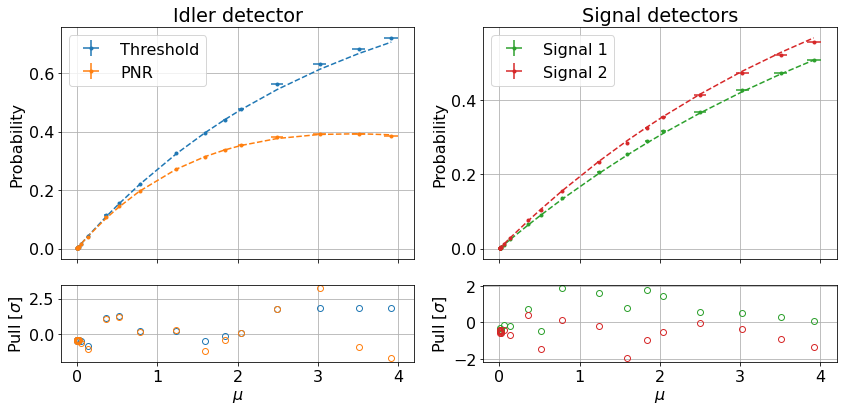

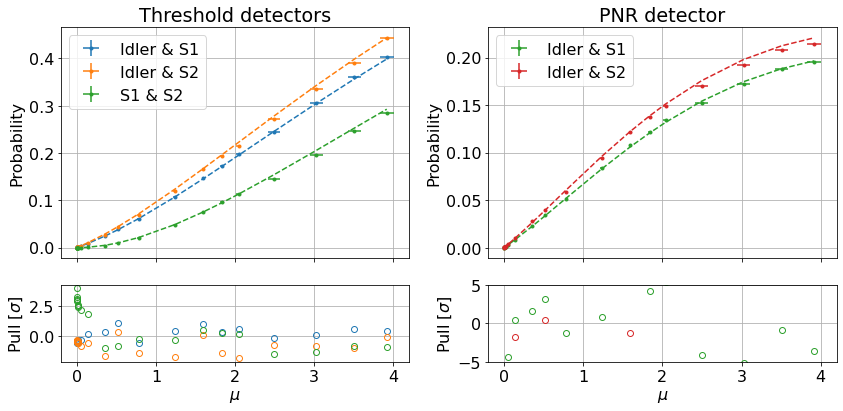

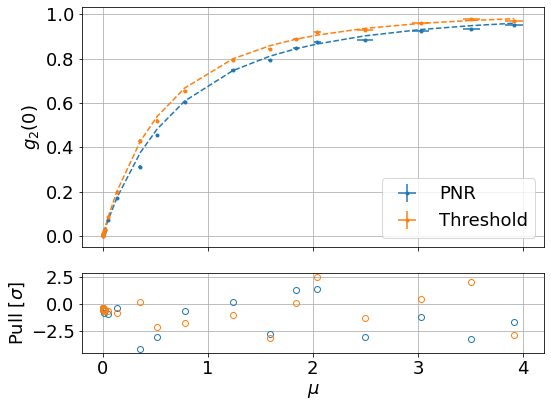

In [10]:
plotSingleDetectors(fr=FitResults())

plotTwofold(fr=FitResults())

plot_g2_0(fr=FitResults())

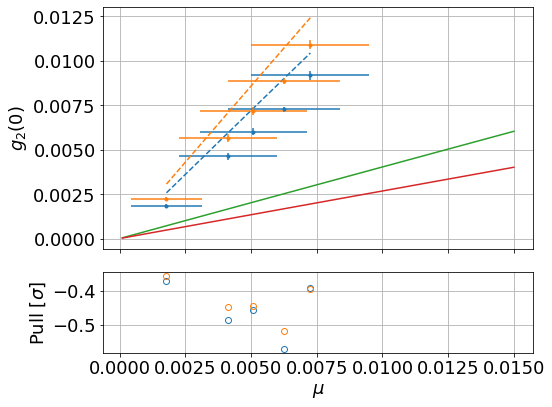

In [11]:
fr = FitResults()
fr.mu = fr.mu[:5]
fr.mu_err = fr.mu_err[:5]

data = df.iloc[:5]
plot_g2_0(data, fr, drawIdealModels=True, showLegend=False)

# The fit

## Base fit

- Fit simultaneous of: $g_2(0)$ in THR and PNR mode.
- Mean photons ($\mu$) gaussian constrained to calibration values.
- Efficiencies ($\eta$) fully correlated among different currents and uncorrelated among detectors. Gaussian prior given by the calibration.
- Uncertainty on Schmidt eigenvalues ($\lambda_s$) given by $\sigma_{xy}^{cwdm} = 13 \pm 1$ nm
- $k$ free to float

In [12]:
inputData = df
eta_constrain = eta0

def cost_NLL(inputs):
    nPts = inputData.shape[0]
    mu = inputs[:nPts]
    eta_i, eta_1, eta_2 = inputs[nPts: nPts+3]
    ls_var = inputs[-2]
    k = inputs[-1]
    
    ls = getLambda(ls_var)
    
    NLL = 0
    
    # Signal counts
#     rate = 1e6
#     dy = inputData['C1_tot'] - rate*countProbaSignal(mu, eta_1, ls)
#     NLL += 0.5*np.sum(np.square(dy/inputData['C1_tot_err']))
    
#     dy = inputData['C2_tot'] - rate*countProbaSignal(mu, eta_2, ls)
#     NLL += 0.5*np.sum(np.square(dy/inputData['C2_tot_err']))
    
#     dy = inputData['C12'] - rate*countProbaS1S2(mu, eta_1, eta_2, ls)
#     NLL += 0.5*np.sum(np.square(dy/inputData['C12_err']))
    
    
    # Threshold detector
    dy = inputData['g2_thr'] - g2_0(mu, eta_i, eta_1, eta_2, 0, ls)
    NLL += 0.5*np.sum(np.square(dy/inputData['g2_thr_err']))
    
    # PNR detector
    dy = inputData['g2_pnr'] - g2_0(mu, eta_i, eta_1, eta_2, k, ls)
    NLL += 0.5*np.sum(np.square(dy/inputData['g2_pnr_err']))
    
    # Contraints
    NLL += 0.5*np.sum(np.square((mu - inputData['mu0'])/inputData['mu0_err']))
    NLL += 0.5*np.square((eta_i - eta_constrain['i'][0]) / eta_constrain['i'][1])
    NLL += 0.5*np.square((eta_1 - eta_constrain['1'][0]) / eta_constrain['1'][1])
    NLL += 0.5*np.square((eta_2 - eta_constrain['2'][0]) / eta_constrain['2'][1])
    NLL += 0.5*np.square(ls_var)
    
    return NLL

cost_NLL.errordef = Minuit.LIKELIHOOD

In [13]:
parNames  = ['mu_'+str(i) for i in range(inputData.shape[0])]
p_0 = list(inputData['mu0'])
parNames += ['eta_i', 'eta_1', 'eta_2']
p_0 += [eta0['i'][0], eta0['1'][0], eta0['2'][0]]
parNames += ['ls_var', 'k']
p_0 += [0, 2.5]
p_0 = np.array(p_0)

print('Initial NLL: {:.1f}'.format(cost_NLL(p_0)))
minimizer = Minuit(cost_NLL, p_0, name=parNames)
minimizer.migrad() # run optimiser
p_hat = np.array(minimizer.values)
print('Final NLL: {:.1f}'.format(cost_NLL(p_hat)))
minimizer.hesse()   # run covariance estimator
p_hat_err = np.array(minimizer.errors)

Initial NLL: 703.9
Final NLL: 53.0


In [14]:
table = PrettyTable()
table.field_names = ['Parameter', 'Input', 'Best fit', 'Unc', 'Pull']
for i, n in enumerate(parNames):
    x0 = p_0[i]
    x_hat = p_hat[i]
    sigma = p_hat_err[i]
    pull = (x_hat - x0)/sigma
    if np.abs(x_hat) > 100: form = '{:.1f}'
    elif np.abs(x_hat) > 0.01: form = '{:.4f}'
    else: form = '{:1.3e}'
    table.add_row([n] + [form.format(val) for val in [x0, x_hat, sigma, pull]])
print(table)

+-----------+-----------+-----------+-----------+------------+
| Parameter |   Input   |  Best fit |    Unc    |    Pull    |
+-----------+-----------+-----------+-----------+------------+
|    mu_0   | 1.778e-03 | 1.304e-03 | 4.078e-05 | -1.161e+01 |
|    mu_1   | 4.113e-03 | 3.280e-03 | 9.964e-05 | -8.354e+00 |
|    mu_2   | 5.088e-03 | 4.223e-03 | 9.960e-05 | -8.680e+00 |
|    mu_3   | 6.258e-03 | 5.168e-03 | 7.240e-05 | -1.505e+01 |
|    mu_4   | 7.255e-03 | 6.443e-03 | 1.206e-04 | -6.735e+00 |
|    mu_5   |   0.0156  |   0.0141  |   0.0001  |  -14.7520  |
|    mu_6   |   0.0201  |   0.0189  |   0.0002  |  -7.1386   |
|    mu_7   |   0.0134  |   0.0118  |   0.0009  |  -1.8292   |
|    mu_8   |   0.0548  |   0.0529  |   0.0010  |  -1.8856   |
|    mu_9   |   0.1378  |   0.1364  |   0.0026  |  -0.5801   |
|   mu_10   |   0.3591  |   0.3235  |   0.0069  |  -5.1413   |
|   mu_11   |   0.5190  |   0.4997  |   0.0069  |  -2.7928   |
|   mu_12   |   0.7806  |   0.7704  |   0.0097  |  -1.0

Text(0.5, 1.0, 'Correlation Matrix')

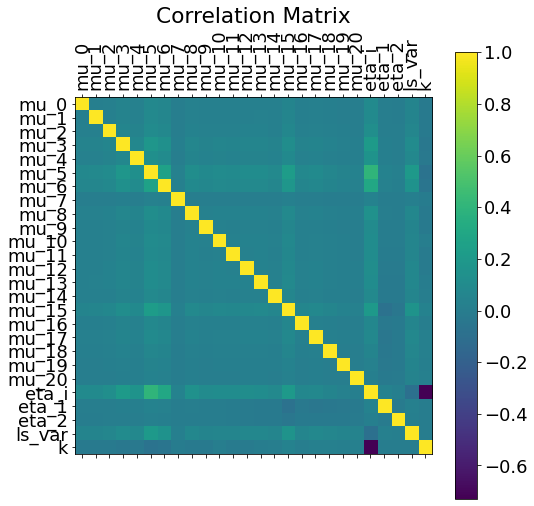

In [18]:
plt.figure(1, figsize=(8,8))
corr = correlation_from_covariance(np.array(minimizer.covariance))
ax = plt.matshow(corr, fignum=1)
plt.xticks(np.arange(len(parNames)), parNames, rotation=90)
plt.yticks(np.arange(len(parNames)), parNames)
plt.colorbar()
plt.title('Correlation Matrix')

In [16]:
fr = FitResults(mu=p_hat[:-5], mu_err=p_hat_err[:-5], 
                eta= {'i': [p_hat[-5], p_hat_err[-5]], 
                      '1': [p_hat[-4], p_hat_err[-4]], 
                      '2': [p_hat[-3], p_hat_err[-3]]},
                modLambda=p_hat[-2], modLambda_err=p_hat_err[-1],
                k=p_hat[-1], k_err=p_hat_err[-1])

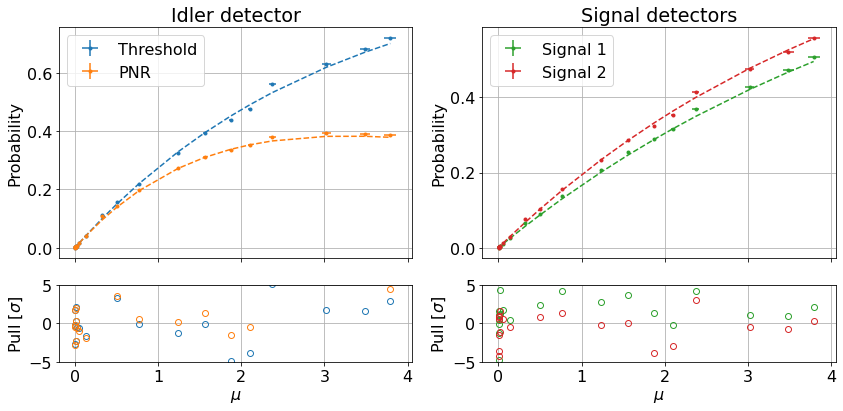

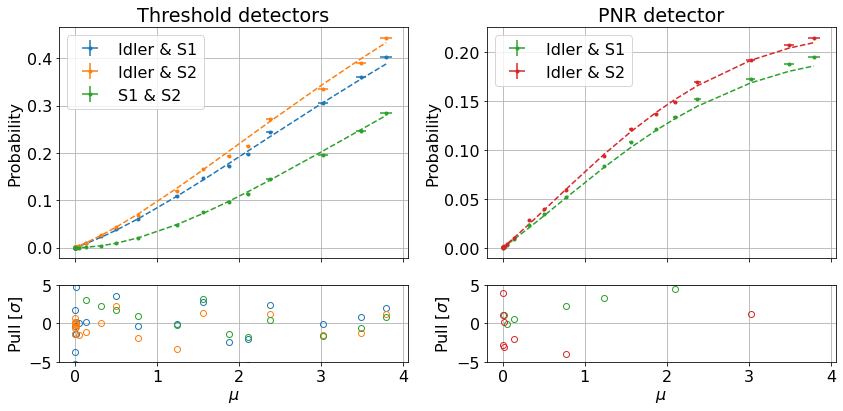

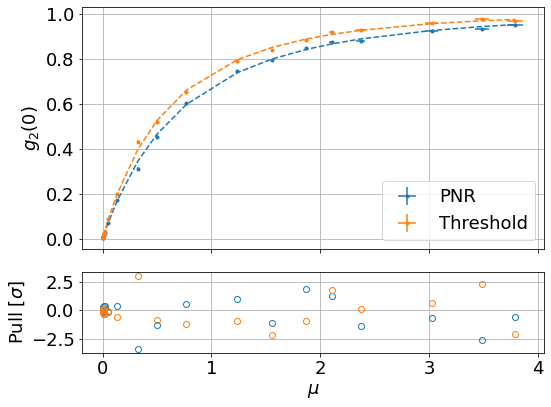

In [17]:
plotSingleDetectors(inputData, fr)

plotTwofold(inputData, fr)

plot_g2_0(inputData, fr)

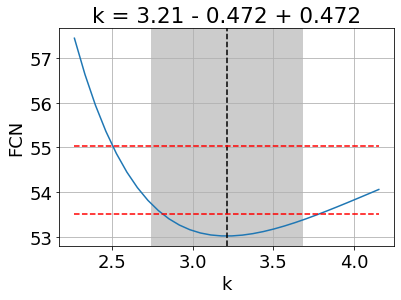

In [21]:
k_arr, NLL_arr = minimizer.draw_mnprofile('k')
plt.grid()
ymin = np.min(NLL_arr)
plt.plot(k_arr, k_arr.shape[0]*[ymin + 0.5], 'r--')
plt.plot(k_arr, k_arr.shape[0]*[ymin + 2], 'r--')

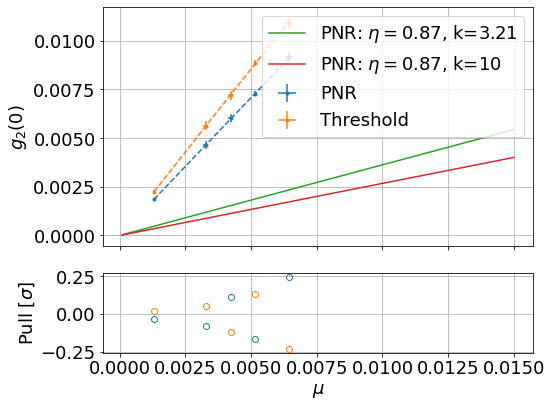

In [25]:
frZoom = deepcopy(fr)
frZoom.mu = frZoom.mu[:5]
frZoom.mu_err = frZoom.mu_err[:5]

plot_g2_0(df.iloc[:5], frZoom, drawIdealModels=True, showLegend=True)